<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
!pip install fastcore==0.1.18
!pip install fastai2==0.0.17
!pip install git+https://github.com/butchland/fastai_xla_extensions.git@595e8b175a7d89197e955ecc7ce3c126ceb1fc02

ERROR: fastai 2.0.0 has requirement fastcore>=1.0.0, but you'll have fastcore 0.1.18 which is incompatible.
  Found existing installation: fastcore 1.0.0
    Uninstalling fastcore-1.0.0:
      Successfully uninstalled fastcore-1.0.0
     |████████████████████████████████| 194kB 3.4MB/s 
  Cloning https://github.com/butchland/fastai_xla_extensions.git (to revision 595e8b175a7d89197e955ecc7ce3c126ceb1fc02) to /tmp/pip-req-build-qh4r6lye
  Running command git clone -q https://github.com/butchland/fastai_xla_extensions.git /tmp/pip-req-build-qh4r6lye
  Running command git checkout -q 595e8b175a7d89197e955ecc7ce3c126ceb1fc02
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=11232 sha256=5828e17d735cb4dd5b167e5f3dad6f03a9ce682c7e215bc355887af85b384c30
  Stored in directory: /tmp/pip-ephem-wheel-cache-f5865zxa/wheels/c0/07/ae/7446ca5cf3b8a407e63f8d1d9f3ebeaf5c613cd32de55a70f2
Successfully built fastai-xla-extensions


In [ ]:
VERSION = "20200325" #@param ["1.5" , "20200707", "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version $VERSION > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  27352      0 --:--:-- --:--:-- --:--:-- 27500
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
\ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
\ [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objects/114.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      
ERROR:

In [ ]:
!pip freeze | grep torch
!pip freeze | grep fastai2
!pip freeze | grep fastcore
!pip freeze | grep fastai-xla-extensions

torch==1.5.0a0+d6149a7
torch-xla==1.6+e788e5b
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0a0+3c254fb
fastai2==0.0.17
fastcore==0.1.18
fastai-xla-extensions==0.0.1


In [ ]:
import fastai_xla_extensions.core

**Import the fastai_xla_extensions core before importing fastai**

In [ ]:
from fastai2.tabular.all import *
from fastai2.collab import *
dede = default_device(); dede

device(type='xla', index=1)

In [ ]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

In [ ]:
ratings = ratings.merge(movies)

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.device

device(type='xla', index=1)

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.946852,0.935425,00:42
1,0.838488,0.862378,00:41
2,0.742397,0.827136,00:43
3,0.599305,0.815220,00:43
4,0.502389,0.815686,00:43


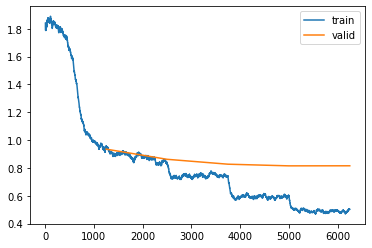

In [ ]:
learn.recorder.plot_loss()

### Interpretation

In [ ]:
g = ratings.groupby("title")['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings.groupby("title")['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3511),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2862),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2769), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2681), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2467), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2448), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2269), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2250), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2236), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2232), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2221), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2158), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2137), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2113), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0